In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep
hep.style.use(hep.style.ATLAS)

path_prefix = '/home/jaySandesara/NSBI_workflow_tutorial/FAIR_universe_Higgs_tautau/'

import os
os.chdir(f"{path_prefix}")

from HiggsML.datasets import download_dataset

In [18]:
data = download_dataset("https://zenodo.org/records/15131565/files/FAIR_Universe_HiggsML_data.zip")

2025-06-01 07:44:49,959 - HiggsML.datasets     - INFO     - Handling as URL: https://zenodo.org/records/15131565/files/FAIR_Universe_HiggsML_data.zip
2025-06-01 07:44:49,960 - HiggsML.datasets     - INFO     - Current working directory: /data/jaySandesara/NSBI_workflow_tutorial/FAIR_universe_Higgs_tautau
2025-06-01 07:44:49,965 - HiggsML.datasets     - INFO     - Total rows: 220099101
2025-06-01 07:44:49,966 - HiggsML.datasets     - INFO     - Test size: 66029730


In [19]:
# Assign an integer with each of the processes (same as the dictionary used to load)
labels_dict = {"htautau": 0,
              "ztautau":1,
              "ttbar":2,
              "diboson":3}

np.save(f"{saved_data}labels_dictionary.npy", labels_dict)


In [20]:
data.load_train_set(train_size=0.05)
df_training = data.get_train_set()

2025-06-01 07:44:56,937 - HiggsML.datasets     - INFO     - Selected train size: 7703468
2025-06-01 07:45:24,609 - HiggsML.datasets     - INFO     - Data loaded successfully


In [21]:
df_training.columns

Index(['PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_had_pt', 'PRI_had_eta',
       'PRI_had_phi', 'PRI_jet_leading_pt', 'PRI_jet_leading_eta',
       'PRI_jet_leading_phi', 'PRI_jet_subleading_pt',
       'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_n_jets',
       'PRI_jet_all_pt', 'PRI_met', 'PRI_met_phi', 'weights',
       'detailed_labels', 'labels', 'DER_mass_transverse_met_lep',
       'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet',
       'DER_prodeta_jet_jet', 'DER_deltar_had_lep', 'DER_pt_tot', 'DER_sum_pt',
       'DER_pt_ratio_lep_had', 'DER_met_phi_centrality',
       'DER_lep_eta_centrality'],
      dtype='object')

In [22]:
path_prefix = '/home/jaySandesara/NSBI_workflow_tutorial/FAIR_universe_Higgs_tautau/'

# Path for saving interemdiate objects, like NN predictions
saved_data = f'{path_prefix}cached_data/'


if not os.path.exists(saved_data):
    print(f"Making new directory for caching data {saved_data}")
    os.makedirs(saved_data)


In [23]:
df_training.detailed_labels.unique()

array(['ztautau', 'htautau', 'ttbar', 'diboson'], dtype=object)

In [24]:
df_training['train_labels'] = -1 

for key in labels_dict:
    df_training.loc[df_training['detailed_labels'] == key, 'train_labels'] = labels_dict[key]


In [40]:
mask_selection = (df_training['PRI_lep_pt']<=500.0) & (df_training['PRI_met']<=400.0)
df_training = df_training[mask_selection].copy()


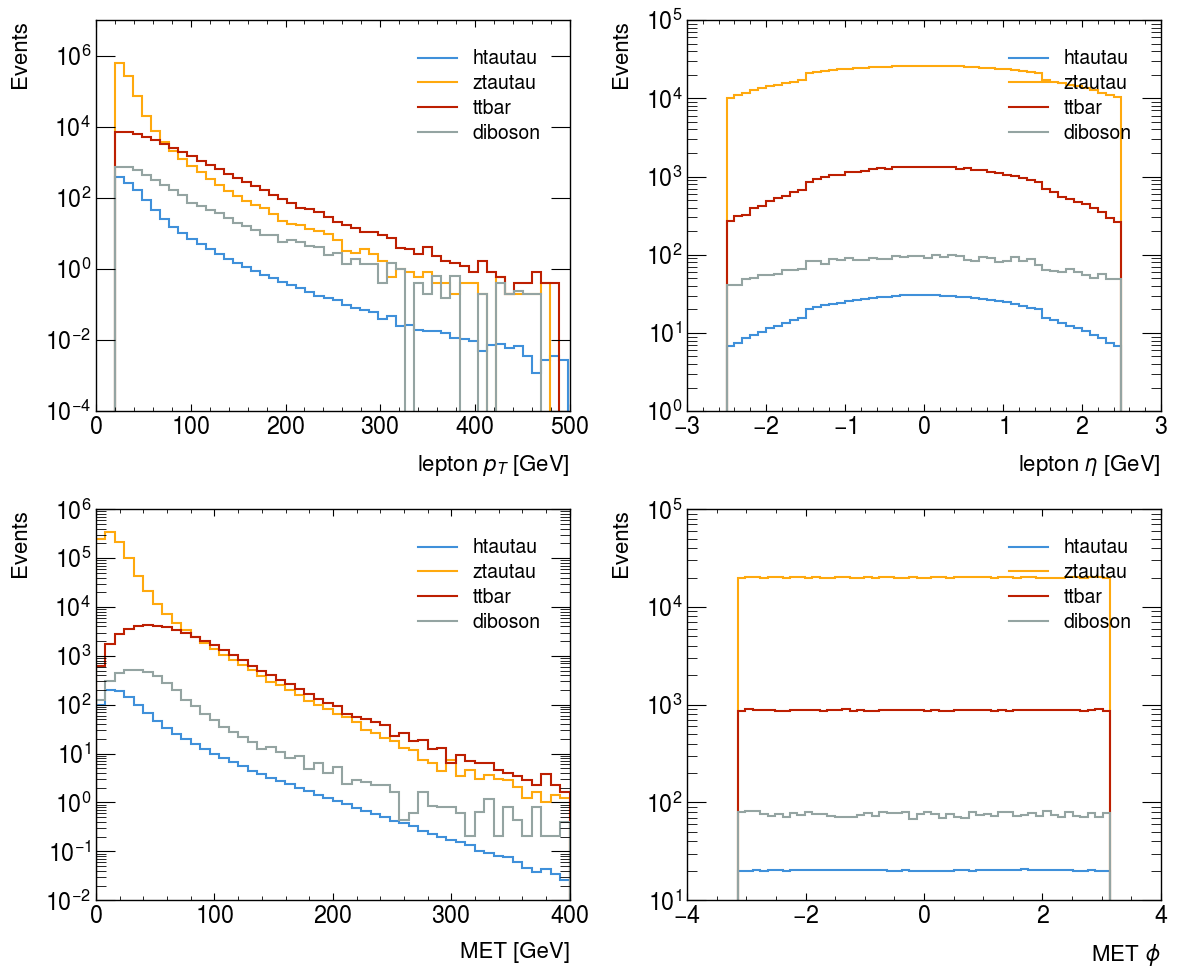

In [41]:
columns = ['PRI_lep_pt', 'PRI_lep_eta', 'PRI_met', 'PRI_met_phi', 'PRI_n_jets']
columns = ['PRI_lep_pt', 'PRI_lep_eta', 'PRI_met', 'PRI_met_phi']
nbins = 50

xlabel_dict = {
    'PRI_lep_pt': 'lepton $p_T$ [GeV]', 
    'PRI_lep_eta': 'lepton $\eta$ [GeV]', 
    'PRI_met': 'MET [GeV]', 
    'PRI_met_phi': 'MET $\phi$',     
    'PRI_n_jets': '$n_{jets}$'      
}

bins_dict = {}
histograms = {}
for feature in columns:

    histograms[feature] = {}

    for count, label in enumerate(labels_dict):

        mask_process = (df_training.detailed_labels == label)

        feature_array = df_training[mask_process][feature].to_numpy()
        weights_array = df_training[mask_process]['weights'].to_numpy()

        if count==0:

            histograms[feature][label], bins = np.histogram(
                feature_array, 
                weights=weights_array, 
                bins=nbins
            )
        else:
            mask_process = (df_training.detailed_labels == label)
            histograms[feature][label], _ = np.histogram(
                feature_array, 
                weights=weights_array, 
                bins=bins
            )

    bins_dict[feature] = bins
            
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

palette = plt.rcParams['axes.prop_cycle'].by_key()['color']

color_label_map = {
    label: palette[i % len(palette)]
    for i,label in enumerate(labels_dict)
}

for count, feature in enumerate(columns):

    for label in labels_dict:

        hep.histplot(histograms[feature][label], bins=bins_dict[feature], label=label, 
                     ax=axes[count], linewidth=1.5, color=color_label_map[label])

    axes[count].set_yscale('log')
    axes[count].set_xlabel(xlabel_dict[feature], size=16)
    axes[count].set_ylabel('Events', size=16)
    axes[count].legend()

plt.tight_layout()
plt.show()


In [42]:
df_training.to_hdf(f"{saved_data}df_inclusive.h5", key="dataset", mode="w")